# PyTorch Rain Prediction

## Preprocessing

In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
Sunshine,47.692924
Evaporation,42.789026
Cloud3pm,40.152469
Cloud9am,37.735332
Pressure9am,9.855619
Pressure3pm,9.832411
WindDir9am,7.041838
WindGustDir,6.561504
WindGustSpeed,6.519308
WindDir3pm,2.656952


In [4]:
df_print = df[['RISK_MM','Location','RainTomorrow']]
df_print.head()

,RISK_MM,Location,RainTomorrow
0,0.0,Albury,No
1,0.0,Albury,No
2,0.0,Albury,No
3,1.0,Albury,No
4,0.2,Albury,No


Considering just the location and RISK_MM (The amount of next day rain in mm. A kind of measure of the "risk") as our features.

In [11]:
df2 = df[['RISK_MM','Location']]
X = pd.get_dummies(df2).values
X = StandardScaler().fit_transform(X)
Y = df['RainTomorrow'].values
Y = LabelEncoder().fit_transform(Y)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

In [12]:
# Converting data from Numpy to Torch Tensors
train = TensorDataset(torch.from_numpy(X_Train).float(), torch.from_numpy(Y_Train).float())
test = TensorDataset(torch.from_numpy(X_Test).float(), torch.from_numpy(Y_Test).float())
# Creating data loaders
trainloader = DataLoader(train, batch_size=128, shuffle=True)
testloader = DataLoader(test, batch_size=128, shuffle=True)

## Modelling

In [41]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=0)
        return out

### Training

In [14]:
# Instatiating the model
model = ANN(50, 20, 1)
print(model)

ANN(
  (fc1): Linear(in_features=50, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


In [15]:
# Defying loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(model.parameters())
# Training loop for each epoch
loss_plot, acc_plot = [], []
for epoch in range(7):
    total_loss, correct, total = 0, 0, 0
    for x, y in trainloader: 
        # Zero the parameter gradients
        optimiser.zero_grad()
        # forward + loss + backward + optimise (update weights)
        output = model(x)
        outputs = output.squeeze(1)
        loss = loss_function(outputs, y)
        loss.backward()
        optimiser.step()
        # Keeping track of the loss
        total_loss += loss.item()
        output = F.softmax(output, dim=0)
        count = [1 for i, j in zip(output, y) if i == j]
        correct += sum(count)
        total += len(y)
        acc = ((100.0 * correct) / total)

    
    print("Epoch: %d, Loss: %4.2f, Accuracy: %2.2f" % (epoch, 
                                                         total_loss, 
                                                           acc) + '%')
    loss_plot.append(total_loss)
    acc_plot.append(acc)

Epoch: 0, Loss: 294.88, Accuracy: 0.13%
Epoch: 1, Loss: 123.58, Accuracy: 6.31%
Epoch: 2, Loss: 62.27, Accuracy: 28.72%
Epoch: 3, Loss: 35.33, Accuracy: 49.40%
Epoch: 4, Loss: 22.99, Accuracy: 64.99%
Epoch: 5, Loss: 16.80, Accuracy: 71.59%
Epoch: 6, Loss: 13.16, Accuracy: 74.13%


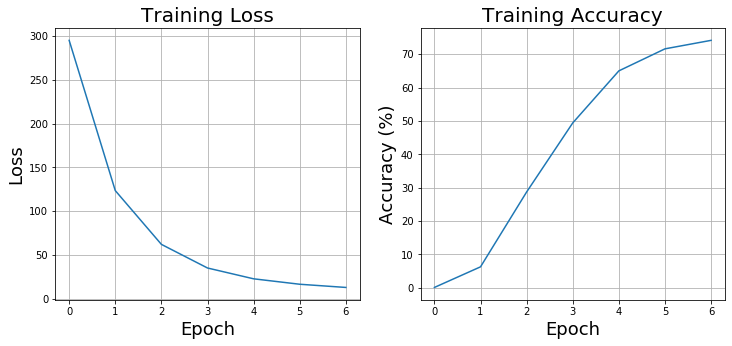

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
#plt.tight_layout()
ax[0].plot(loss_plot)
ax[0].grid(True)
ax[0].set_title("Training Loss", fontsize=20);
ax[0].set_xlabel("Epoch", fontsize=18);
ax[0].set_ylabel("Loss", fontsize=18);
ax[1].plot(acc_plot)
ax[1].grid(True)
ax[1].set_title("Training Accuracy", fontsize=20);
ax[1].set_xlabel("Epoch", fontsize=18);
ax[1].set_ylabel("Accuracy (%)", fontsize=18);
plt.savefig("Training.png", format='png', dpi=1200)

### Evaluation

In [17]:
model.eval()
# Computing the model accuracy on the test set
correct, total = 0, 0
for x, y in testloader:
    output = model(x)
    count = [1 for i, j in zip(output, y) if i == j]
    correct += sum(count)
    total += len(y)

print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))

Test Accuracy: 74.66 %


## Alternative Implementation (using CrossEntropyLoss)

In [18]:
# Instatiating the model
model2 = ANN(50, 20, 2)
# Definying cross entrophy loss function and optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model2.parameters())

for epoch in range(7):
    running_loss = 0.0
    for x, y in trainloader: 
        # Zero parameter gradients
        optimiser.zero_grad()
        # Forward pass, loss function, backward pass and weights update
        outputs = model2(x)
        loss = loss_function(outputs, y.long())
        loss.backward()
        optimiser.step()
        # Keeping track of the loss
        running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))

Epoch 0, loss 278.33
Epoch 1, loss 88.38
Epoch 2, loss 35.79
Epoch 3, loss 19.73
Epoch 4, loss 14.03
Epoch 5, loss 11.35
Epoch 6, loss 9.70


In [20]:
model2.eval()

# Computing the model accuracy on the test set
correct, total = 0, 0
for x, y in testloader:
    outputs = model2(x)
    winners = outputs.argmax(dim=1)
    count = [1 for i, j in zip(winners, y.long()) if i == j]
    correct += sum(count)
    total += len(y)
print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))

Test Accuracy: 80.38 %


### Adding More Features

In [53]:
df2 = df[['RISK_MM','Location']]
X = pd.get_dummies(df2).values
X = StandardScaler().fit_transform(X)
Y = df['RainTomorrow'].values
Y = LabelEncoder().fit_transform(Y)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)
X_Train, X_Valid, Y_Train, Y_Valid = train_test_split(X_Train, Y_Train, test_size = 0.30, random_state = 101)
# Converting data from Numpy to Torch Tensors
train = TensorDataset(torch.from_numpy(X_Train).float(), torch.from_numpy(Y_Train).float())
valid = TensorDataset(torch.from_numpy(X_Valid).float(), torch.from_numpy(Y_Valid).float())
test = TensorDataset(torch.from_numpy(X_Test).float(), torch.from_numpy(Y_Test).float())
# Creating data loaders
trainloader = DataLoader(train, batch_size=128, shuffle=True)
validloader = DataLoader(valid, batch_size=128, shuffle=True)
testloader = DataLoader(test, batch_size=128, shuffle=True)

In [48]:
class ANN2(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(ANN2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [56]:
# Instatiating the model
model3 = ANN2(50, 30, 10, 1)
# Defying loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(model3.parameters())
# Training loop for each epoch
loss_plot, acc_plot = [], []
val_loss_plot, val_acc_plot = [], []
for epoch in range(12):
    total_loss, correct, total = 0, 0, 0
    model3.train()
    for x, y in trainloader: 
        # Zero the parameter gradients
        optimiser.zero_grad()
        # forward + loss + backward + optimise (update weights)
        output = model3(x)
        outputs = output.squeeze(1)
        loss = loss_function(outputs, y)
        loss.backward()
        optimiser.step()
        # Keeping track of the loss
        total_loss += loss.item() 
        output = F.softmax(output, dim=0)
        count = [1 for i, j in zip(output, y) if i == j]
        correct += sum(count)
        total += len(y)
    val_total_loss, val_correct, val_total = 0, 0, 0
    model3.eval()
    for x, y in validloader: 
        output = model3(x)
        outputs = output.squeeze(1)
        val_loss = loss_function(outputs, y)
        # Keeping track of the loss
        val_total_loss += val_loss.item()
        output = F.softmax(output, dim=0)
        val_count = [1 for i, j in zip(output, y) if i == j]
        val_correct += sum(val_count)
        val_total += len(y)

    acc = ((100.0 * correct) / total)
    val_acc = ((100.0 * val_correct) / val_total)
    epoch_loss = total_loss / len(trainloader)
    val_epoch_loss = val_total_loss / len(testloader)
    print("Epoch: %d, Loss: %4.2f, Accuracy: %2.2f" % (epoch, 
                                                         epoch_loss, 
                                                           acc) + '%')
    print("Validation, Loss: %4.2f, Accuracy: %2.2f" % (val_epoch_loss, 
                                                           val_acc) + '%')
    loss_plot.append(total_loss)
    acc_plot.append(acc)
    val_loss_plot.append(val_total_loss)
    val_acc_plot.append(val_acc)

Epoch: 0, Loss: 0.37, Accuracy: 0.06%
Validation, Loss: 0.09, Accuracy: 4.00%
Epoch: 1, Loss: 0.06, Accuracy: 28.37%
Validation, Loss: 0.02, Accuracy: 50.34%
Epoch: 2, Loss: 0.02, Accuracy: 63.10%
Validation, Loss: 0.01, Accuracy: 70.71%
Epoch: 3, Loss: 0.02, Accuracy: 72.77%
Validation, Loss: 0.01, Accuracy: 74.29%
Epoch: 4, Loss: 0.02, Accuracy: 76.32%
Validation, Loss: 0.01, Accuracy: 77.42%
Epoch: 5, Loss: 0.01, Accuracy: 76.81%
Validation, Loss: 0.01, Accuracy: 78.11%
Epoch: 6, Loss: 0.01, Accuracy: 77.56%
Validation, Loss: 0.01, Accuracy: 78.14%
Epoch: 7, Loss: 0.01, Accuracy: 78.00%
Validation, Loss: 0.01, Accuracy: 78.33%
Epoch: 8, Loss: 0.01, Accuracy: 77.88%
Validation, Loss: 0.01, Accuracy: 78.42%
Epoch: 9, Loss: 0.01, Accuracy: 78.19%
Validation, Loss: 0.01, Accuracy: 78.53%
Epoch: 10, Loss: 0.01, Accuracy: 78.20%
Validation, Loss: 0.01, Accuracy: 78.53%
Epoch: 11, Loss: 0.01, Accuracy: 78.22%
Validation, Loss: 0.01, Accuracy: 78.51%


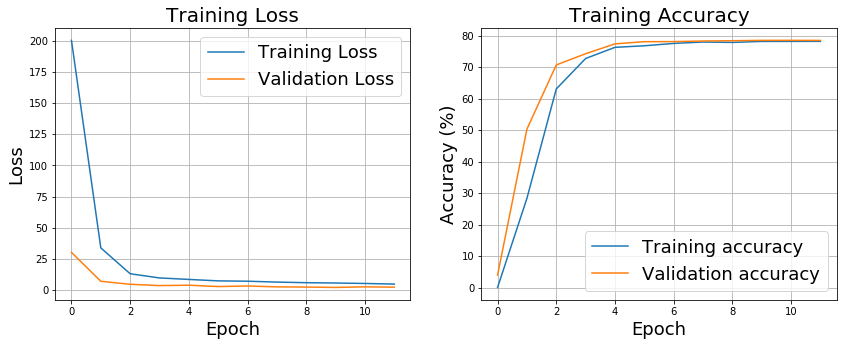

In [66]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    #plt.tight_layout()
    ax[0].plot(loss_plot, label="Training Loss")
    ax[0].plot(val_loss_plot, label="Validation Loss")
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_title("Training Loss", fontsize=20);
    ax[0].set_xlabel("Epoch", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training accuracy")
    ax[1].plot(val_acc_plot, label="Validation accuracy")
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_title("Training Accuracy", fontsize=20);
    ax[1].set_xlabel("Epoch", fontsize=18);
    ax[1].set_ylabel("Accuracy (%)", fontsize=18);
    #plt.savefig("Training.png", format='png', dpi=1200)
    
train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)

In [61]:
def test_model(model, testloader):
    model.eval()
    # Computing the model accuracy on the test set
    correct, total = 0, 0
    for x, y in testloader:
        outputs = model(x)
        winners = outputs.argmax(dim=1)
        count = [1 for i, j in zip(winners, y.long()) if i == j]
        correct += sum(count)
        total += len(y)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    
test_model(model3, testloader)

Test Accuracy: 77.56 %


#### Complete Implementation

In [113]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_plot, acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # Next two lines enable us to use Binary Crossentropy
                    #outputs = outputs.squeeze(1)
                    #loss = criterion(outputs, labels)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)
    return model

Epoch 0/9
----------
train Loss: 0.5342 Acc: 0.7750
val Loss: 0.5053 Acc: 0.7788

Epoch 1/9
----------
train Loss: 0.4869 Acc: 0.7814
val Loss: 0.4515 Acc: 0.7970

Epoch 2/9
----------
train Loss: 0.4094 Acc: 0.8207
val Loss: 0.3524 Acc: 0.8533

Epoch 3/9
----------
train Loss: 0.3032 Acc: 0.8739
val Loss: 0.2499 Acc: 0.8997

Epoch 4/9
----------
train Loss: 0.2125 Acc: 0.9137
val Loss: 0.1753 Acc: 0.9315

Epoch 5/9
----------
train Loss: 0.1524 Acc: 0.9392
val Loss: 0.1280 Acc: 0.9506

Epoch 6/9
----------
train Loss: 0.1122 Acc: 0.9564
val Loss: 0.0972 Acc: 0.9635

Epoch 7/9
----------
train Loss: 0.0958 Acc: 0.9629
val Loss: 0.0938 Acc: 0.9633

Epoch 8/9
----------
train Loss: 0.0932 Acc: 0.9637
val Loss: 0.0914 Acc: 0.9641

Epoch 9/9
----------
train Loss: 0.0909 Acc: 0.9650
val Loss: 0.0892 Acc: 0.9651

Training complete in 0m 50s
Best val Acc: 0.965105


ANN2(
  (fc1): Linear(in_features=50, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

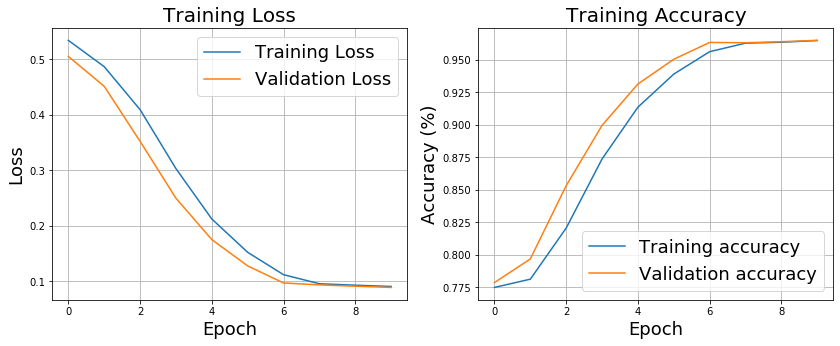

In [114]:
from torch.optim import lr_scheduler
import time
import copy

dataloaders = {'train': trainloader, 'val': validloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(validloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model4 = ANN2(50, 30, 10, 2)
criterion = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
optimizer_ft = optim.SGD(model4.parameters(), lr=0.001, momentum=0.9)
# Decaying learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
train_model(model4, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

In [115]:
test_model(model4, testloader)

Test Accuracy: 96.63 %
